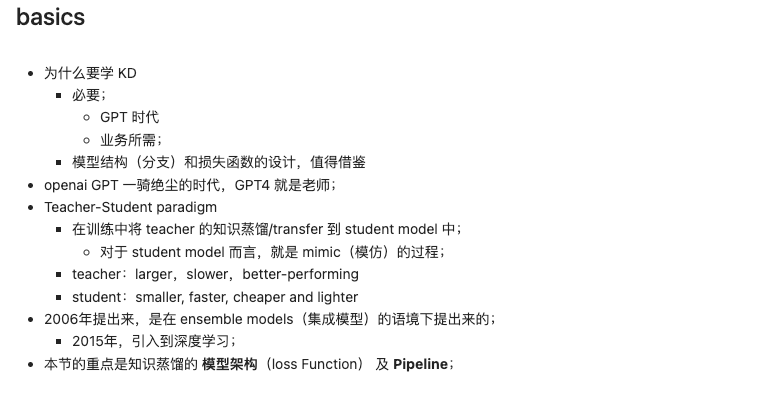

In [6]:
from IPython.display import Image

Image('./imgs/img_2.png', width=300)

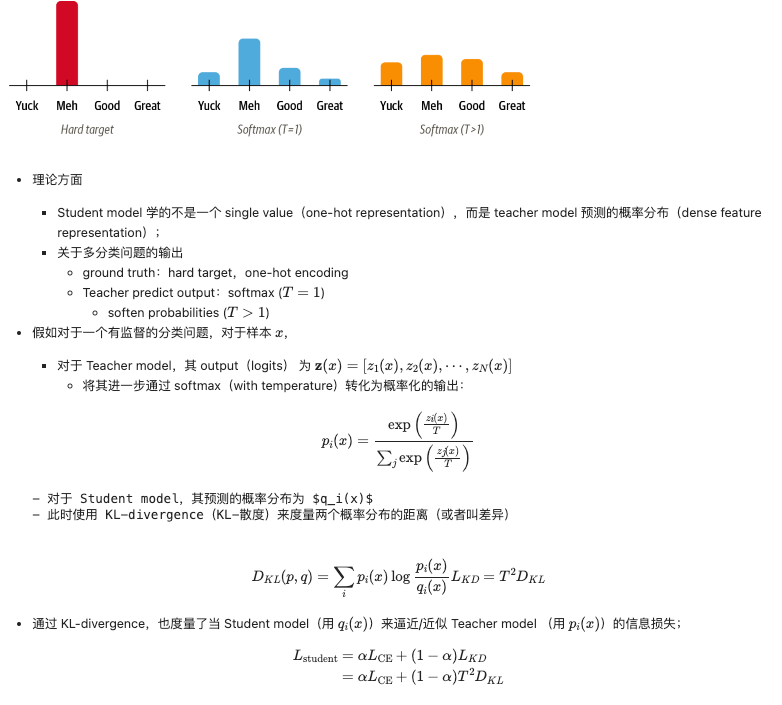

In [7]:
Image('./imgs/img_3.png', width=300)

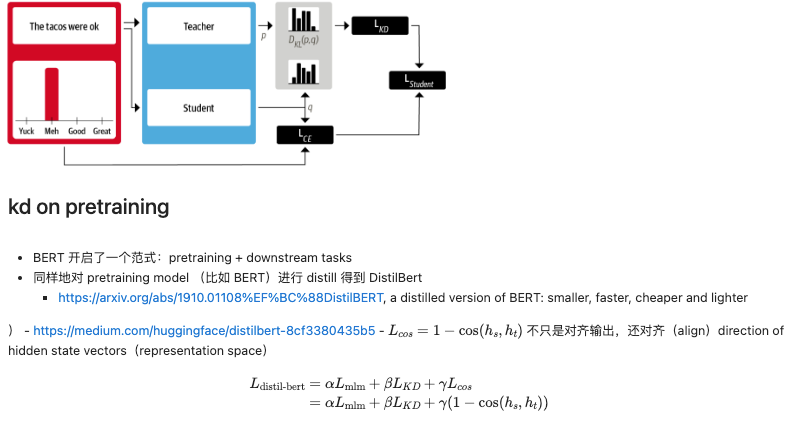

In [8]:
Image('./imgs/img_4.png', width=300)

#### review
![avatar](./imgs/img_1.png)

#### trainer arguments & trainer

In [1]:
from transformers import Trainer, TrainingArguments
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import wandb

In [3]:
class DistillTrainingArguments(TrainingArguments):
    # TrainingArguments: @dataclass
    # 增加两个 KD 所需的参数参数
    def __init__(self, *args, alpha=0.5, temperature=2., **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [7]:
class DistillTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        s_output = model(**inputs)
        s_ce = s_output.loss
        s_logits = s_output.logits

        with torch.no_grad():
            t_output = self.teacher_model(**inputs)
            t_logits = t_output.logits

        loss_kl_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_kl_fct(
            F.log_softmax(s_logits / self.args.temperature, dim=-1),
            F.softmax(t_logits / self.args.temperature, dim=-1),
        )

        loss = self.args.alpha * s_ce + (1 - self.args.alpha) * loss_kd
        return (loss, s_output) if return_outputs else loss

#### pipeline
##### datasets

In [8]:
# import os
# os.environ['HTTP_PROXY'] = 'http://192.168.0.103:2022'
# os.environ['HTTPS_PROXY'] = 'http://192.168.0.103:2022'

In [11]:
from datasets import load_dataset

dataset_dir = '/home/server/zhuyue/datasets/clinc_oos/plus'
clinc = load_dataset(dataset_dir)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /home/server/.cache/huggingface/datasets/parquet/plus-ec046810c9ca3ccb/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
})

In [13]:
clinc['train'][:10]

{'text': ['what expression would i use to say i love you if i were an italian',
  "can you tell me how to say 'i do not speak much spanish', in spanish",
  "what is the equivalent of, 'life is good' in french",
  "tell me how to say, 'it is a beautiful morning' in italian",
  'if i were mongolian, how would i say that i am a tourist',
  "how do i say 'hotel' in finnish",
  "i need you to translate the sentence, 'we will be there soon' into portuguese",
  'please tell me how to ask for a taxi in french',
  "can you tell me how i would say, 'more bread please' in french",
  "what is the correct way to say 'i am a visitor' in french"],
 'intent': [61, 61, 61, 61, 61, 61, 61, 61, 61, 61]}

In [14]:
intents = clinc['train'].features['intent']
num_labels = intents.num_classes
num_labels

151

#### Student model初始化

In [16]:
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

s_ckpt = 'distilbert-base-uncased'
s_tokenizer = AutoTokenizer.from_pretrained(s_ckpt)

t_ckpt = 'transformersbook/bert-base-uncased-finetuned-clinc'
t_model = AutoModelForSequenceClassification.from_pretrained(t_ckpt, num_labels=num_labels).to(device)

In [31]:
clinc_enc = clinc.map(lambda batch: s_tokenizer(batch['text'], truncation=True),
                      batched=True,
                      remove_columns=["text"]
                      )
clinc_enc = clinc_enc.rename_columns({'intent': 'labels'})
clinc_enc

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 15250
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5500
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3100
    })
})

In [32]:
batch_size = 64
s_training_args = DistillTrainingArguments(
    output_dir='distilbert-base-uncased-ft-clinc',
    evaluation_strategy='epoch',
    num_train_epochs=5,
    learning_rate=3e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    alpha=0.5,
    weight_decay=0.01,
    logging_strategy='epoch',
    push_to_hub=False
)
s_config = AutoConfig.from_pretrained(
    s_ckpt,
    num_labels=num_labels,
    id2label=t_model.config.id2label,
    label2id=t_model.config.label2id
)

In [33]:
def student_init():
    return AutoModelForSequenceClassification.from_pretrained(s_ckpt, config=s_config).to(device)

#### trainer.train

In [34]:
import evaluate

accuracy_score = evaluate.load('accuracy')

In [35]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=-1)

    return accuracy_score.compute(references=labels, predictions=predictions)

In [36]:
distill_trainier = DistillTrainer(
    model_init=student_init,
    teacher_model=t_model,
    args=s_training_args,
    train_dataset=clinc_enc['train'],
    eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics,
    tokenizer=s_tokenizer
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

In [37]:
distill_trainier.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Epoch,Training Loss,Validation Loss


/home/server/anaconda3/envs/llm/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/server/anaconda3/envs/llm/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/server/anaconda3/envs/llm/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/server/anaconda3/envs/llm/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was a

TrainOutput(global_step=300, training_loss=0.4918929131825765, metrics={'train_runtime': 84.2956, 'train_samples_per_second': 904.555, 'train_steps_per_second': 3.559, 'total_flos': 486982817716500.0, 'train_loss': 0.4918929131825765, 'epoch': 5.0})